# Basic mCT Pipeline

The reconstructionm pipeline, assuming that the sinograms are available in the form of stored numpy arrays (`npy` files).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## PET Projector

In [2]:
from odlpet import Compression, Scanner

In [3]:
%run mct.py

In [4]:
c = Compression(mCT())

In [469]:
c.num_of_views = 168
#c.num_non_arccor_bins = 400
c.num_non_arccor_bins = 200
c.data_arc_corrected = True
c.span_num = 11
# the following is new:
c.max_num_segments = 45

In [470]:
c.scanner.num_rings

55

In [579]:
#proj = c.get_projector(stir_domain=c.get_stir_domain(sizes=(109,200,200)), restrict_to_cylindrical_FOV=False)
proj = c.get_projector(stir_domain=c.get_stir_domain(zoom=.5),restrict_to_cylindrical_FOV=False)

In [472]:
proj.domain

uniform_discr([   0., -400., -400.], [ 226.72,  408.  ,  408.  ], (109, 101, 101), dtype='float32')

In [473]:
%%time
proj(proj.domain.one());

CPU times: user 20.5 s, sys: 116 ms, total: 20.6 s
Wall time: 20.5 s


uniform_discr([   0.,    0., -421.], [ 621.    ,    3.1416,  421.    ], (621, 168, 200), dtype='float32').element(
    [[[  0.      ,  15.      ,  21.      , ...,  25.      ,  21.      ,
        15.      ],
      [  0.      ,  15.002622,  21.003674, ...,  25.004375,  21.003674,
        15.002622],
      [  0.      ,  15.010498,  21.0147  , ...,  25.017498,  21.0147  ,
        15.010498],
      ..., 
      [  0.      ,  15.023633,  21.033089, ...,  25.039387,  21.033089,
        15.023633],
      [  0.      ,  15.010498,  21.0147  , ...,  25.017498,  21.0147  ,
        15.010498],
      [  0.      ,  15.002622,  21.003674, ...,  25.004375,  21.003674,
        15.002622]],
    
     [[  0.      ,  15.      ,  21.      , ...,  25.      ,  21.      ,
        15.      ],
      [  0.      ,  15.002622,  21.003674, ...,  25.004375,  21.003674,
        15.002622],
      [  0.      ,  15.010498,  21.0147  , ...,  25.017498,  21.0147  ,
        15.010498],
      ..., 
      [  0.      ,  15.0236

## Read some sinogram (already stored in NumPy format)

In [474]:
from pathlib import Path

In [475]:
base_path = Path("/mnt/data/olivierv/")

In [476]:
data_path = base_path / "Decompressed"

In [477]:
!ls {data_path}/*npy

/mnt/data/olivierv/Decompressed/P00.npy
/mnt/data/olivierv/Decompressed/P01.npy
/mnt/data/olivierv/Decompressed/P02.npy


In [478]:
import numpy as np

In [479]:
sino_arrays = [ np.load(data_path / 'P0{}.npy'.format(i)) for i in range(3)]

## Reconstruction

Choose the bed position:

In [480]:
bed_position = 0

In [481]:
data = sino_arrays[bed_position]

Unfortunately, we can't scale the projector up to 400 tangential coordinates, so we have to downsample the data instead:

In [482]:
data.shape

(621, 168, 400)

In [483]:
data_ = (data[...,::2] + data[...,1::2])/2

In [484]:
data_.shape

(621, 168, 200)

In [485]:
sino = proj.range.element(data_)

Initialise the reconstruction.

In [486]:
recon = proj.domain.one()
iters = 0

In [487]:
import odl

In [24]:
%%time
nb_iters = 2
odl.solvers.iterative.statistical.mlem(proj, recon, sino, niter=nb_iters)
iters += nb_iters
print(iters, recon.asarray().max())
#show_slice(phantom, 20);

2 0.0242567
CPU times: user 1min 17s, sys: 728 ms, total: 1min 18s
Wall time: 1min 13s


### Save Reconstruction

In [26]:
save_dir = base_path / "cylrecos"

In [27]:
save_path = save_dir / "reco-{}-{}-{}.npy".format(bed_position, recon.shape[1], iters)

In [28]:
print(save_path)

/mnt/data/olivierv/cylrecos/reco-0-101-2.npy


In [136]:
np.save(save_path, recon)

## Load Existing Reconstruction

In [488]:
!ls {save_dir}

reco-0-101-2.npy  reco-1-101-2.npy  reco-2-101-2.npy  reco2.npy


In [489]:
reco2 = np.load(save_dir / 'reco-2-101-2.npy')

In [490]:
reco0 = np.load(save_dir / 'reco-0-101-2.npy')

In [491]:
reco2.shape

(109, 101, 101)

In [492]:
reco2 = proj.domain.element(reco2)

In [493]:
reco0 = proj.domain.element(reco0)

In [494]:
reco2.space

uniform_discr([   0., -400., -400.], [ 226.72,  408.  ,  408.  ], (109, 101, 101), dtype='float32')

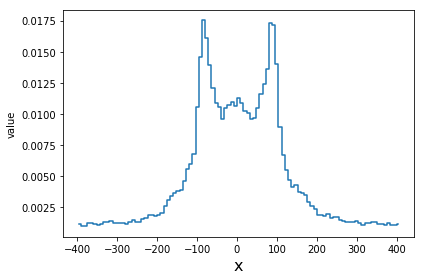

<Figure size 432x288 with 0 Axes>

In [495]:
reco2.show(coords=(200,0,None));

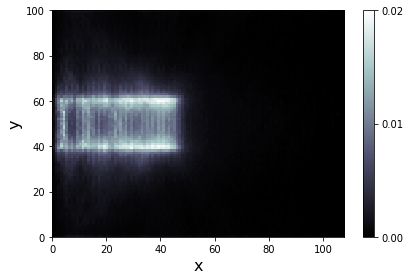

<Figure size 432x288 with 0 Axes>

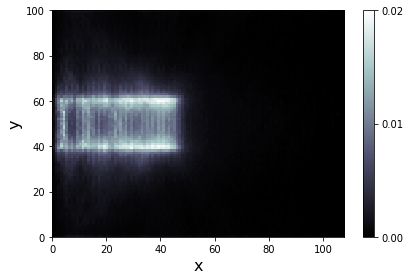

In [496]:
#reco2[45].show(aspect='equal');
reco0[:,45,:].show()

In [497]:
reco0.shape

(109, 101, 101)

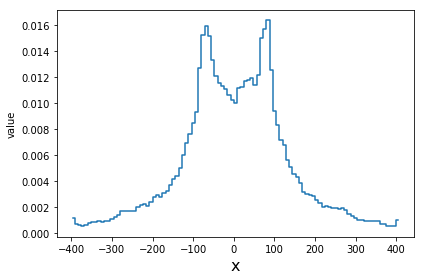

<Figure size 432x288 with 0 Axes>

In [498]:
#reco2.show(coords=(None,0,None));
reco0.show(coords=(45,50,None));

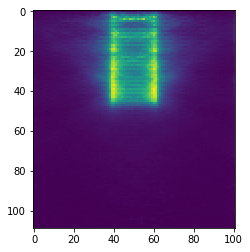

In [499]:
plt.imshow(reco0[:,45,:])

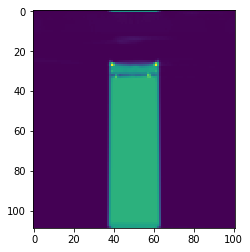

In [500]:
plt.imshow(reg_attenuation_final[:,45,:])

Here I try to include attenuation correction

# Read in DICOM files

In [501]:
from path import Path
import pydicom

ct_dir_path = Path('/mnt/data/olivierv/Cyl/AC_CT_0003/')

# Create volume with slices in right order

In [68]:
%%time
#volume = np.array([pydicom.dcmread(f).pixel_array for f in ct_dir_path.listdir()])

imas = [pydicom.dcmread(f) for f in ct_dir_path.listdir()]

shuffled_volume = np.array([ima.pixel_array for ima in imas])

pos = [int(ima.InstanceNumber) - 1 for ima in imas]

volumect = np.zeros_like(shuffled_volume)

volumect[pos] = shuffled_volume

CPU times: user 440 ms, sys: 64 ms, total: 504 ms
Wall time: 520 ms


### Convert HU to attenuation values

first HU are rescaled:

In [525]:
dummy = pydicom.dcmread(ct_dir_path.listdir()[0])
volumect_ = dummy.RescaleSlope*volumect.astype(np.float) + dummy.RescaleIntercept

Then the values are translated from HU to linear attenuation coefficient at 551 keV, in units cm$^{-1}$.
(probably we need a rescaling for the pixel size as well!)
This is done following formula (from Carney Med Phys 33(4) 2006 (https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.2174132)):

If  x<  breakpoint, then  f(x)=(x+1000)9.6×10−5 

If  x>  breakpoint, then  f(x)=a(x+1000)+b 

Note: the conversion values above depend on the kV

p, and are obtained from table III from Carney above:

In [86]:
#this can be certainly done in a more elegant way, but the following works I hope:
kvp = dummy.KVP
if kvp == 80 : 
        a = 3.64e-5
        b=6.261e-2
        breakpoint=50
if kvp == 100 : 
        a = 4.43e-5
        b=5.44e-2
        breakpoint=52
if kvp == 110 : 
        a = 4.92e-5
        b=4.88e-2
        breakpoint=43
if kvp == 120 : 
        a = 5.1e-5
        b=4.71e-2
        breakpoint=47
if kvp == 130 : 
        a = 5.51e-5
        b=4.24e-2
        breakpoint=37
if kvp == 140 : 
        a = 5.64e-5
        b=4.08e-2
        breakpoint=30
def attenuation_conversion(volume, breakpoint, a, b):
    attenuation = np.zeros_like(volume)
    small = volume < breakpoint
    attenuation[small] = (volume[small] + 1000)*(9.6e-5)
    attenuation[~small] = a*(volume[~small] + 1000) + b
    attenuation = attenuation
    return attenuation

In [560]:
attenuation = attenuation_conversion(volumect_, breakpoint, a, b)#/10*float(dummy.PixelSpacing[0]) 
#the last multiplication is for scaling for the pixel size (works only for isotropic case, it makes no sense in this case
#for the z-direction, which has a different spacing.

# unfortunately some values can end up being negative
attenuation[attenuation < 0] = 0

In [527]:
1/(float(dummy.PixelSpacing[0])/10)

6.564102564102564

Registration and downsamplig of the mu_map 
(The following now works only for this particular case in which, by hand, I have registered the PET and CT images and come up with the fact that the CT image should be moved forward by 13 slices in the z direction (which is the first index). The solution of using the function roll is good as long as there are no attenuation structures in the last 13 slices (this is not exaclty true here). I am also guessing the slice thickness in the two cases, tryng to understand what the field of view for bed0 is and how many slices from the CT I should take. All of this is very approximative, still, for an homogeneous cylinder, if i got things slightly right, the attenuation correction should be ok.)

In [561]:
from skimage.transform import resize
n_slice_from_reg = 13
reg_attenuation = np.roll(attenuation, n_slice_from_reg, axis=0)
reg_attenuation_b0 = reg_attenuation[0:132,:,:]
new_size_i = 101
new_size_j = 101
down_size = (133,101,101)
inter_size = (109,101,200)
final_size = (109,101,101)
reg_attenuation_down = np.zeros(down_size)
for z in range(133):
    slice_or = reg_attenuation_b0[z-1,:,:]
#slice_down = np.zeros[new_size_i,new_size_j]
    slice_down = resize(slice_or,(new_size_i, new_size_j), anti_aliasing=True)
    reg_attenuation_down[z] = slice_down
reg_attenuation_inter = np.zeros(inter_size)
reg_attenuation_final = np.zeros(final_size)
for i in range(101):
    slice_z = reg_attenuation_down[:,:,i-1]
    slice_z_down = resize(slice_z,(109,101), anti_aliasing=True)
    reg_attenuation_final[:,:,i-1] = slice_z_down

/opt/tljh/user/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


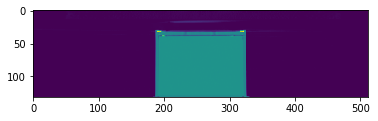

In [562]:
plt.imshow(reg_attenuation_b0[:,250,:])

In [563]:
reg_attenuation_final = reg_attenuation_final*512/101
reversed_arr = np.swapaxes(np.swapaxes(reg_attenuation_final, 0, 0)[::-1], 0, 0)

In [588]:
proj_attenuated = odl.MultiplyOperator(np.exp(-proj(reversed_arr/2)))*proj

In [575]:
sinocorr = np.exp(proj(reversed_arr))*sino

In [589]:
#%%time
#nb_iters = 1
#odl.solvers.iterative.statistical.mlem(proj_attenuated, recon, sino, niter=nb_iters)
#iters += nb_iters
mlem = odl.solvers.iterative.statistical.mlem
#mlem = odl.solvers.mlem

recon = proj.domain.one()
mlem(proj_attenuated, recon, sino, niter=18)
#mlem(proj, recon, sinocorr, niter=2)

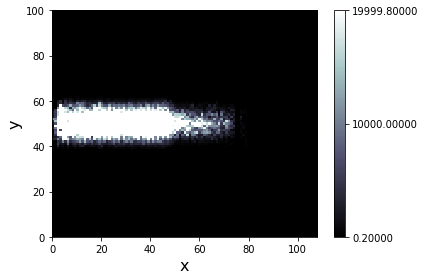

<Figure size 432x288 with 0 Axes>

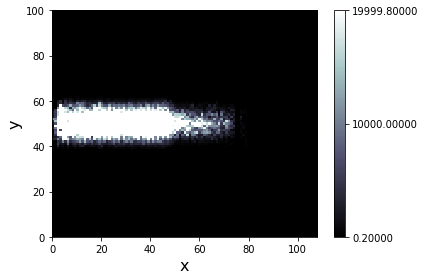

In [586]:
recon[:,50,:].show(clim=[0,20000])

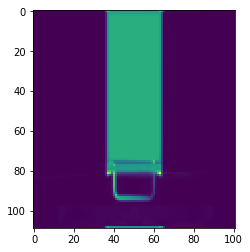

In [542]:
plt.imshow(reversed_arr[:,50,:])

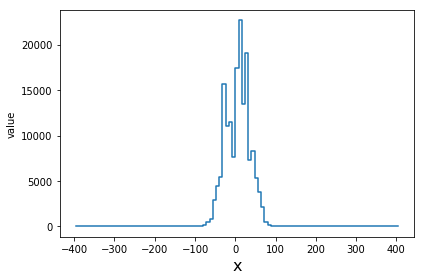

<Figure size 432x288 with 0 Axes>

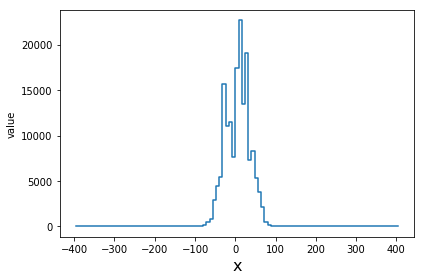

In [587]:
recon.show(coords=(50,50,None))

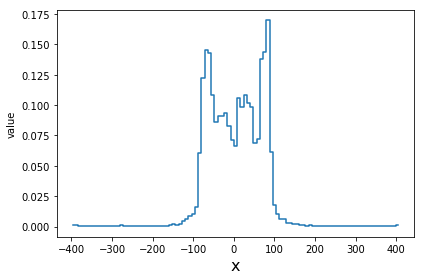

<Figure size 432x288 with 0 Axes>

In [458]:
recon.show(coords=(45,50,None));

In [306]:
reg_attenuation_final.shape

(109, 101, 101)

In [564]:

reversed_arr = np.swapaxes(np.swapaxes(reg_attenuation_final, 0, 0)[::-1], 0, 0)
#for z in range(101):
#    reg_attenuation_final_r[:,z-1,:]=np.rot90(reg_attenuation_final[:,z-1,:], k=-1,axes=(0,1))
#reg_attenuation_final_rs = reg_attenuation_final_r.T
#reg_attenuation_final_rs = np.swapaxes(reg_attenuation_final_r,2,0)    

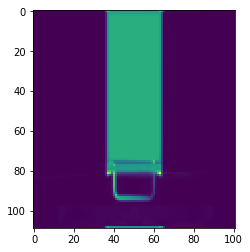

In [423]:
plt.imshow(reversed_arr[:,50,:])

In [403]:
reversed_arr.shape

(109, 101, 101)

In [235]:
slice_or = reg_attenuation_b0[50,:,:]
slice_down = resize(slice_or,(new_size_i, new_size_j), anti_aliasing=True)
reg_attenuation_down = np.zeros(down_size)
reg_attenuation_down[50,:,:]=slice_down*512/200

/opt/tljh/user/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


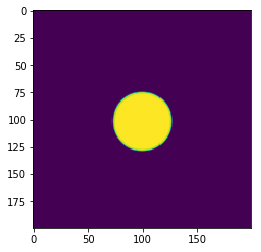

In [225]:
plt.imshow(slice_down)

In [226]:
slice_down.shape

(200, 200)

In [ ]:
reg_attenuation_down[50,:,:]=slice_down*512/200

In [237]:
reg_attenuation_down.shape

(133, 200, 200)